**Import packages**

In [ ]:
!pip install pytictoc

In [ ]:
!pip install tensorflow

In [ ]:
import random
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pytictoc import TicToc
warnings.filterwarnings( "ignore" )

**Load the dataset**

In [ ]:
(X_train, y_train), (X_test,y_test) = datasets.mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

**Create helper functions**

In [ ]:
def plot_sample_image(X, y):
    plt.figure(figsize = (15,2))
    plt.imshow(X)
    classes = ["0","1","2","3","4","5","6","7","8","9"]
    plt.xlabel('Image Label: {}'.format(classes[y]))

def classification_results(X_test,y_test,y_pred_classes):
  from sklearn.metrics import confusion_matrix , classification_report
  import seaborn as sn

  cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_classes)
  plt.figure(figsize = (7,5))
  sn.heatmap(cm, annot=True, fmt='d', cmap='Greens')
  plt.xlabel('Predicted');
  plt.ylabel('Truth');

  print("Classification Report: \n", classification_report(y_test, y_pred_classes))

def plot_fitting_history(history,filename,dpi):
  epochs = len(history.history['loss'])
  epoch_data = np.arange(1,epochs+1)
  plt.plot(epoch_data,history.history['loss'],'o-')
  plt.plot(epoch_data,history.history['val_loss'],'o--')
  plt.ylabel('Loss')
  plt.xlabel('Epoch sequence' )
  plt.xticks(np.arange(0, epochs + 1, step=1))
  plt.legend(['Training','Validation'])
  plt.savefig(filename, dpi=dpi)
  plt.show()

**Plot sample image**

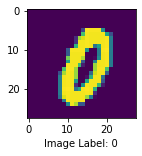

In [ ]:
index = np.random.randint(100)
plot_sample_image(X_train[index], y_train[index])

**Normalize the input data**

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/ECE 696B/Project - ECE696B
# %cd /content/gdrive/MyDrive/Colab Notebooks

# Create adversarial examples for training

In [ ]:
indexes = np.arange(0,5000);
noise = np.random.normal(size=X_train[indexes].shape, loc=0.0, scale=0.1)
X_train_noisy_1 = X_train[indexes] + noise
X_train_noisy_1 = np.clip(X_train_noisy_1, 0, 1)

indexes = np.arange(5000,7500);
noise = np.random.normal(size=X_train[indexes].shape, loc=0.0, scale=0.2)
X_train_noisy_2 = X_train[indexes] + noise
X_train_noisy_2 = np.clip(X_train_noisy_2, 0, 1)

indexes = np.arange(7500,8750);
noise = np.random.normal(size=X_train[indexes].shape, loc=0.0, scale=0.3)
X_train_noisy_3 = X_train[indexes] + noise
X_train_noisy_3 = np.clip(X_train_noisy_3, 0, 1)

indexes = np.arange(8750, 9375);
noise = np.random.normal(size=X_train[indexes].shape, loc=0.0, scale=0.4)
X_train_noisy_4 = X_train[indexes] + noise
X_train_noisy_4 = np.clip(X_train_noisy_4, 0, 1)

indexes = np.arange(9375, 10000);
noise = np.random.normal(size=X_train[indexes].shape, loc=0.0, scale=0.5)
X_train_noisy_5 = X_train[indexes] + noise
X_train_noisy_5 = np.clip(X_train_noisy_5, 0, 1)

X_train_noisy = np.concatenate((X_train_noisy_1, X_train_noisy_2, X_train_noisy_3,\
                                X_train_noisy_4, X_train_noisy_5), axis = 0)

indexes = range(10000)
avg_l2_norm = np.mean(np.sqrt(np.sum((X_train_noisy-X_train[indexes])**2, axis=(1,2))))
print("Average l2 distance of the perturbation:", avg_l2_norm)

Average l2 distance of the perturbation: 3.894527079981553


In [ ]:
X_train_stack = np.concatenate((X_train, X_train_noisy), axis = 0)
y_train_stack = np.concatenate((y_train, y_train[indexes]), axis = 0)

p = np.random.permutation(len(X_train_stack))
X_train_stack, y_train_stack = X_train_stack[p], y_train_stack[p]

X_train_stack.shape, y_train_stack.shape

((70000, 28, 28), (70000,))

# Adversarial training of Linear model

In [ ]:
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Linear_MNIST = models.Sequential([
        layers.Flatten(input_shape=X_train.shape[1:]),
        layers.Dense(10, activation='softmax'),  
    ])

learning_rate =  0.001
Linear_MNIST.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_C_Linear_GNA = Linear_MNIST.fit(X_train_stack, y_train_stack, epochs=50, batch_size=32,
            validation_split = 0.2, callbacks = early_callbacks, verbose=1, shuffle = True)

Epoch 1/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.4949 - accuracy: 0.8706 - val_loss: 0.3328 - val_accuracy: 0.9076
Epoch 2/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.3166 - accuracy: 0.9126 - val_loss: 0.3024 - val_accuracy: 0.9141
Epoch 3/50
1750/1750 [==============================] - 6s 4ms/step - loss: 0.2926 - accuracy: 0.9194 - val_loss: 0.2914 - val_accuracy: 0.9168
Epoch 4/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.2805 - accuracy: 0.9221 - val_loss: 0.2864 - val_accuracy: 0.9180
Epoch 5/50
1750/1750 [==============================] - 7s 4ms/step - loss: 0.2721 - accuracy: 0.9256 - val_loss: 0.2854 - val_accuracy: 0.9181
Epoch 6/50
1750/1750 [==============================] - 6s 3ms/step - loss: 0.2658 - accuracy: 0.9271 - val_loss: 0.2864 - val_accuracy: 0.9182
Epoch 7/50
1750/1750 [==============================] - 6s 3ms/step - loss: 0.2615 - accuracy: 0.9281 - val_loss: 0.2837 - val_accuracy:

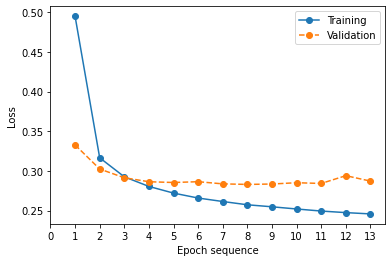

In [ ]:
filename = 'GNA Adversarial Training history MNIST [Linear]'+'.png'
plot_fitting_history(history_C_Linear_GNA, filename, dpi = 100)

313/313 [==============================] - 1s 1ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.91      0.91      0.91      1010
           4       0.92      0.93      0.93       982
           5       0.90      0.87      0.89       892
           6       0.95      0.94      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.89      0.88      0.88       974
           9       0.89      0.92      0.90      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



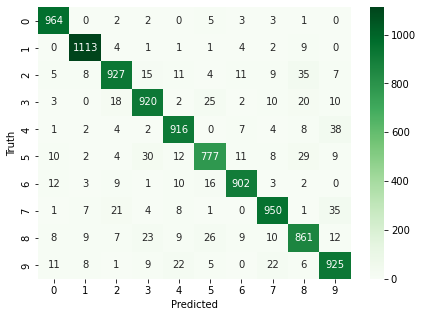

In [ ]:
y_pred = Linear_MNIST.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
classification_results(X_test,y_test,y_pred_classes)

In [ ]:
Linear_MNIST.save('Linear_MNIST_GNA_trained.h5')

# Adversarial training of MLP model

In [ ]:
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

MLP_MNIST = models.Sequential([
        layers.Flatten(input_shape=X_train.shape[1:]),
        layers.Dense(2**6, activation='relu'),
        layers.Dense(10, activation='softmax')    
    ])

learning_rate =  0.001
MLP_MNIST.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_C_MLP_GNA = MLP_MNIST.fit(X_train_stack, y_train_stack, epochs=50, batch_size=32,
            validation_split = 0.2, callbacks = early_callbacks, verbose=1, shuffle = True)

Epoch 1/50
1750/1750 [==============================] - 8s 4ms/step - loss: 0.3275 - accuracy: 0.9069 - val_loss: 0.1935 - val_accuracy: 0.9430
Epoch 2/50
1750/1750 [==============================] - 6s 3ms/step - loss: 0.1543 - accuracy: 0.9559 - val_loss: 0.1607 - val_accuracy: 0.9509
Epoch 3/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.1070 - accuracy: 0.9689 - val_loss: 0.1349 - val_accuracy: 0.9594
Epoch 4/50
1750/1750 [==============================] - 11s 6ms/step - loss: 0.0826 - accuracy: 0.9761 - val_loss: 0.1104 - val_accuracy: 0.9651
Epoch 5/50
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0656 - accuracy: 0.9810 - val_loss: 0.1072 - val_accuracy: 0.9665
Epoch 6/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0546 - accuracy: 0.9841 - val_loss: 0.1053 - val_accuracy: 0.9669
Epoch 7/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0457 - accuracy: 0.9863 - val_loss: 0.1056 - val_accuracy

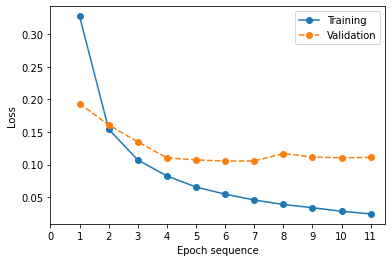

In [ ]:
filename = 'GNA Adversarial Training history MNIST [MLP]'+'.png'
plot_fitting_history(history_C_MLP_GNA, filename, dpi = 100)

313/313 [==============================] - 1s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.96      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.98      0.95      0.96       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.98      0.97      0.97     10000



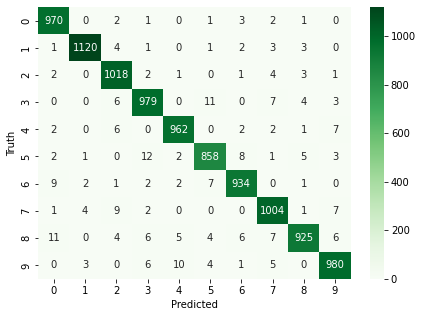

In [ ]:
y_pred = MLP_MNIST.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
classification_results(X_test,y_test,y_pred_classes)

In [ ]:
MLP_MNIST.save('MLP_MNIST_GNA_trained.h5')

# Adversarial training of CNN model

In [ ]:
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

CNN_MNIST = models.Sequential([
    layers.Conv2D(filters=2**4, kernel_size=(3, 3), padding = 'same', 
                  activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(2**4, activation='relu'),
    layers.Dense(10, activation='softmax')
])

learning_rate =  0.001
CNN_MNIST.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_C_CNN_GNA = CNN_MNIST.fit(X_train_stack, y_train_stack, epochs=50, batch_size=32,
            validation_split = 0.2, callbacks = early_callbacks, verbose=1, shuffle = True)

Epoch 1/50
1750/1750 [==============================] - 21s 12ms/step - loss: 0.3144 - accuracy: 0.9051 - val_loss: 0.1296 - val_accuracy: 0.9619
Epoch 2/50
1750/1750 [==============================] - 19s 11ms/step - loss: 0.1040 - accuracy: 0.9693 - val_loss: 0.0945 - val_accuracy: 0.9707
Epoch 3/50
1750/1750 [==============================] - 18s 10ms/step - loss: 0.0744 - accuracy: 0.9780 - val_loss: 0.0813 - val_accuracy: 0.9751
Epoch 4/50
1750/1750 [==============================] - 20s 11ms/step - loss: 0.0582 - accuracy: 0.9828 - val_loss: 0.0732 - val_accuracy: 0.9779
Epoch 5/50
1750/1750 [==============================] - 19s 11ms/step - loss: 0.0501 - accuracy: 0.9847 - val_loss: 0.0762 - val_accuracy: 0.9764
Epoch 6/50
1750/1750 [==============================] - 19s 11ms/step - loss: 0.0421 - accuracy: 0.9876 - val_loss: 0.0721 - val_accuracy: 0.9776
Epoch 7/50
1750/1750 [==============================] - 18s 10ms/step - loss: 0.0365 - accuracy: 0.9889 - val_loss: 0.0728 -

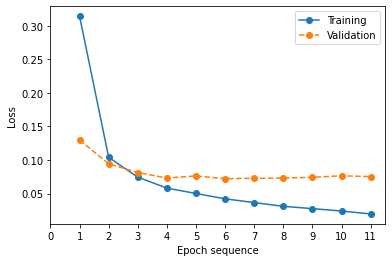

In [ ]:
filename = 'GNA Adversarial Training history MNIST [CNN]'+'.png'
plot_fitting_history(history_C_CNN_GNA, filename, dpi = 100)

313/313 [==============================] - 1s 4ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       0.99      0.98      0.99       958
           7       0.96      0.99      0.97      1028
           8       0.98      0.97      0.98       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



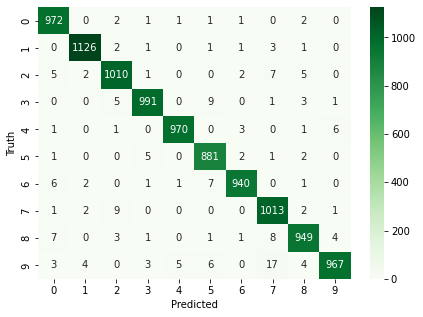

In [ ]:
y_pred = CNN_MNIST.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
classification_results(X_test,y_test,y_pred_classes)

In [ ]:
CNN_MNIST.save('CNN_MNIST_GNA_trained.h5')

# Evaluate performance of adversarial training

**Evaluate performance on unperturbed data**

In [ ]:
%cd C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B
from keras.models import load_model
Linear_MNIST = load_model('Linear_MNIST_GNA_trained.h5')
MLP_MNIST = load_model('MLP_MNIST_GNA_trained.h5')
CNN_MNIST = load_model('CNN_MNIST_GNA_trained.h5')

C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B


In [ ]:
%cd C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\GNA

C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\GNA


In [ ]:
indexes = range(1000)
print('Test accuracy on unperturbed data')
Linear_MNIST.evaluate(X_test[indexes],y_test[indexes])
MLP_MNIST.evaluate(X_test[indexes],y_test[indexes])
CNN_MNIST.evaluate(X_test[indexes],y_test[indexes])
print()

Test accuracy on unperturbed data
32/32 [==============================] - 0s 2ms/step - loss: 0.0516 - accuracy: 0.9800



**Evaluate performance on perturbed data**

In [ ]:
sigmas = np.arange(0,1.1,0.1)
stored_results = []
for i in sigmas:
  print(f'Sigma value: {np.round(i,1)}')
  stored_results.append(i)
    
  filename = 'MNIST_X_test_noisy_GNA_sigma' + str(np.round(i,1)) + '.npy'
  X_test_noisy = np.load(filename)
  
  avg_l2_norm = np.mean(np.sqrt(np.sum((X_test_noisy-X_test[indexes])**2, axis=(1,2))))
  stored_results.append(avg_l2_norm)
  print("Average l2 distance of the perturbation:", avg_l2_norm)

  print('\nTest accuracy on perturbed data')
  _,Linear_MNIST_test_accuray = Linear_MNIST.evaluate(X_test_noisy,y_test[indexes])
  stored_results.append(Linear_MNIST_test_accuray)

  _,MLP_MNIST_test_accuray = MLP_MNIST.evaluate(X_test_noisy,y_test[indexes])
  stored_results.append(MLP_MNIST_test_accuray)

  _,CNN_MNIST_test_accuray = CNN_MNIST.evaluate(X_test_noisy,y_test[indexes])
  stored_results.append(CNN_MNIST_test_accuray)

  print('\n')

Sigma value: 0.0
Average l2 distance of the perturbation: 0.0

Test accuracy on perturbed data
32/32 [==============================] - 0s 2ms/step - loss: 0.0516 - accuracy: 0.9800


Sigma value: 0.1
Average l2 distance of the perturbation: 2.066130566536646

Test accuracy on perturbed data
32/32 [==============================] - 0s 2ms/step - loss: 0.0560 - accuracy: 0.9780


Sigma value: 0.2
Average l2 distance of the perturbation: 4.067851809879554

Test accuracy on perturbed data
32/32 [==============================] - 0s 2ms/step - loss: 0.0920 - accuracy: 0.9690


Sigma value: 0.3
Average l2 distance of the perturbation: 6.0360986091056335

Test accuracy on perturbed data
32/32 [==============================] - 0s 2ms/step - loss: 0.1902 - accuracy: 0.9470


Sigma value: 0.4
Average l2 distance of the perturbation: 7.875701370291492

Test accuracy on perturbed data
32/32 [==============================] - 0s 2ms/step - loss: 0.5720 - accuracy: 0.8550


Sigma value: 0.5
Averag

In [ ]:
stored_results = np.array(stored_results)
stored_results = stored_results.reshape(-1,5)
df = pd.DataFrame(stored_results, columns = ['sigma','avg_l2_norm','Linear_MNIST_test_accuray',\
                                 'MLP_MNIST_test_accuray','CNN_MNIST_test_accuray'])
df.to_csv('Post training Adversarial_Attacks_MNIST [Gaussian Noise Attack].csv', index=False)
df

,sigma,avg_l2_norm,Linear_MNIST_test_accuray,MLP_MNIST_test_accuray,CNN_MNIST_test_accuray
0,0.0,0.000000,0.915,0.971,0.980
1,0.1,2.066131,0.911,0.966,0.978
2,0.2,4.067852,0.885,0.945,0.969
3,0.3,6.036099,0.827,0.901,0.947
4,0.4,7.875701,0.761,0.813,0.855
5,0.5,9.512929,0.635,0.685,0.727
6,0.6,10.834168,0.534,0.573,0.543
7,0.7,11.929506,0.453,0.498,0.453
8,0.8,12.802479,0.421,0.446,0.381
9,0.9,13.493691,0.385,0.373,0.314


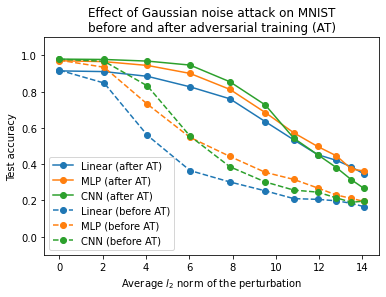

In [ ]:
df = pd.read_csv('Post training Adversarial_Attacks_MNIST [Gaussian Noise Attack].csv')
plt.plot(df['avg_l2_norm'],df['Linear_MNIST_test_accuray'],'o-')
plt.plot(df['avg_l2_norm'],df['MLP_MNIST_test_accuray'],'o-')
plt.plot(df['avg_l2_norm'],df['CNN_MNIST_test_accuray'],'o-')

df = pd.read_csv('Adversarial_Attacks_MNIST [Gaussian Noise Attack].csv')
plt.plot(df['avg_l2_norm'],df['Linear_MNIST_test_accuray'],'o--', color = 'C0')
plt.plot(df['avg_l2_norm'],df['MLP_MNIST_test_accuray'],'o--', color = 'C1')
plt.plot(df['avg_l2_norm'],df['CNN_MNIST_test_accuray'],'o--', color = 'C2')

plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
            'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.title('Effect of Gaussian noise attack on MNIST\nbefore and after adversarial training (AT)')
plt.savefig('Post training Effect of Gaussian noise attack on MNIST [l2 norm]', dpi=600)
plt.show()

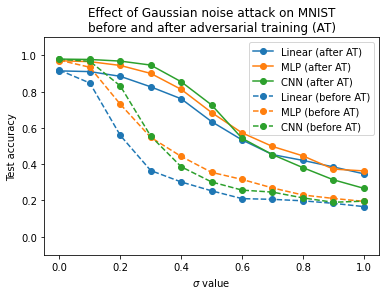

In [ ]:
df = pd.read_csv('Post training Adversarial_Attacks_MNIST [Gaussian Noise Attack].csv')
plt.plot(df['sigma'],df['Linear_MNIST_test_accuray'],'o-')
plt.plot(df['sigma'],df['MLP_MNIST_test_accuray'],'o-')
plt.plot(df['sigma'],df['CNN_MNIST_test_accuray'],'o-')

df = pd.read_csv('Adversarial_Attacks_MNIST [Gaussian Noise Attack].csv')
plt.plot(df['sigma'],df['Linear_MNIST_test_accuray'],'o--', color = 'C0')
plt.plot(df['sigma'],df['MLP_MNIST_test_accuray'],'o--', color = 'C1')
plt.plot(df['sigma'],df['CNN_MNIST_test_accuray'],'o--', color = 'C2')

plt.xlabel('$\sigma$ value')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
            'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.title('Effect of Gaussian noise attack on MNIST\nbefore and after adversarial training (AT)')
plt.savefig('Post training Effect of Gaussian noise attack on MNIST [sigma]', dpi=600)
plt.show()